In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary


# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import confusion_matrix
import seaborn as sns

import shutil

import warnings
warnings.filterwarnings("ignore")

In [4]:
BATCH_SIZE = 128
LR = 0.0001

In [5]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [6]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [7]:
import zipfile
path_to_zip_file = "/content/gdrive/MyDrive/FlowerDataset/dataset/Dataset2.zip"
directory_to_extract_to = "/content/Dataset2/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [8]:
output_dir = "/content/kaggle"

In [9]:
train_dataset = datasets.ImageFolder(root='/content/Dataset2/V2/Training Data/', transform=train_transform)
test_dataset = datasets.ImageFolder(root='/content/Dataset2/V2/Testing Data/', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/content/Dataset2/V2/Validation Data/', transform=train_transform)

In [41]:
class_names=train_dataset.classes
print(class_names)
print(len(class_names))

['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid', 'Poppy', 'Rose', 'Sunflower']
10


In [53]:
# Class Names
root_path = '/content/Dataset2/V2/Training Data/'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]

# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

# Visualize 
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

Total Number of Classes : 10 
Class Names : ['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid', 'Poppy', 'Rose', 'Sunflower']


In [54]:
# Visualize 
fig = px.bar(x=class_names, y=class_dis, title="Class Distribution", color=class_names)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [55]:
# Class Names
valid_path = '/content/Dataset2/V2/Validation Data/'

# Class Distribution
class_dis = [len(os.listdir(valid_path + name)) for name in class_names]

# Visualize 
fig = px.bar(x=class_names, y=class_dis, title="Validation Class Distribution", color=class_names)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [56]:
# Class Names
test_path = '/content/Dataset2/V2/Testing Data/'

# Class Distribution
class_dis = [len(os.listdir(test_path + name)) for name in class_names]

# Visualize 
fig = px.bar(x=class_names, y=class_dis, title="Testing Class Distribution", color=class_names)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [11]:
# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# Define the ResNet18 architecture
class ResNet18(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [13]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
# Initialize the model and move it to the device
model = ResNet18(num_classes = len(class_names)).to(device)

In [15]:

# Display the model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


Now starting epoch: 1
Epoch [1/40], Train Loss: 1.0016, Train Accuracy: 67.29 %
Epoch [1/40], Validation Loss: 0.8608, Validation Accuracy: 70.30 %
Saving model checkpoint...
Now starting epoch: 2
Epoch [2/40], Train Loss: 0.5591, Train Accuracy: 82.31 %
Epoch [2/40], Validation Loss: 0.8153, Validation Accuracy: 74.08 %
Saving model checkpoint...
Now starting epoch: 3
Epoch [3/40], Train Loss: 0.4977, Train Accuracy: 83.95 %
Epoch [3/40], Validation Loss: 0.7085, Validation Accuracy: 77.96 %
Saving model checkpoint...
Now starting epoch: 4
Epoch [4/40], Train Loss: 0.4595, Train Accuracy: 85.03 %
Epoch [4/40], Validation Loss: 0.8519, Validation Accuracy: 73.92 %
Validation loss did not improve. Patience left: 6
Now starting epoch: 5
Epoch [5/40], Train Loss: 0.4317, Train Accuracy: 86.23 %
Epoch [5/40], Validation Loss: 0.8228, Validation Accuracy: 74.96 %
Validation loss did not improve. Patience left: 5
Now starting epoch: 6
Epoch [6/40], Train Loss: 0.4073, Train Accuracy: 86.76 %

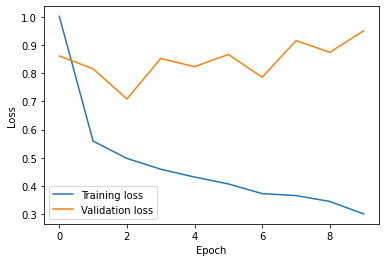

In [27]:
# Train the model
num_epochs = 40
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 7  # number of epochs to wait for improvement
metrics = []


for epoch in range(num_epochs):
    print(f"Now starting epoch: {epoch+1}")
    # Train the model on the training set

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate the training loss
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    #print('Epoch [%d/%d], Train Loss: %.4f' % (epoch+1, num_epochs, train_loss))
    print('Epoch [%d/%d], Train Loss: %.4f, Train Accuracy: %.2f %%' % (epoch+1, num_epochs, train_loss, train_accuracy))

    """model.train()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate the training loss and accuracy
        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total
        print('Epoch [%d/%d], Train Loss: %.4f, Train Accuracy: %.2f %%' % (epoch+1, num_epochs, train_loss, train_accuracy))"""

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_dataloader)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        print('Epoch [%d/%d], Validation Loss: %.4f, Validation Accuracy: %.2f %%' % (epoch+1, num_epochs, val_loss, val_accuracy))
        metrics.append([epoch+1,train_loss,val_loss,train_accuracy,val_accuracy])

        
        # Checkpoint the model if the validation loss has improved (Early stopping)
        if val_loss < best_val_loss:
            print("Saving model checkpoint...")
            best_val_loss = val_loss
            checkpoint = {'epoch': epoch+1,
                          'state_dict': model.state_dict(),
                          'optimizer': optimizer.state_dict(),
                          'train_loss': train_loss,
                          'val_loss': val_loss}
            torch.save(checkpoint, 'model_checkpoint.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience left: {patience - patience_counter}")
            if patience_counter >= patience:
                print("Stopping training due to early stopping...")
                break
        
    # Switch the model back to training mode
    model.train()

print('Finished Training')

# Plot the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
best_checkpoint = torch.load('/content/model_checkpoint.pth')
print(best_checkpoint.keys())
model.load_state_dict(best_checkpoint['state_dict'])

dict_keys(['epoch', 'state_dict', 'optimizer', 'train_loss', 'val_loss'])


<All keys matched successfully>

In [29]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate the test loss and accuracy
    test_loss = running_loss / len(test_dataloader)
    test_accuracy = 100 * correct / total
    print('Test Loss: %.4f, Test Accuracy: %.2f %%' % (test_loss, test_accuracy))

Test Loss: 0.7562, Test Accuracy: 76.65 %


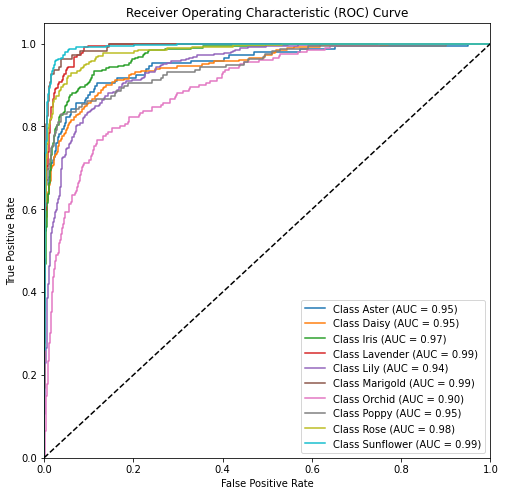

In [30]:
# Calculate the ROC curve and AUC for each class
#model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    all_labels = []
    all_probs = []
    true_labels = []
    pred_labels = []
    all_preds = []
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = %.2f)' % (roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

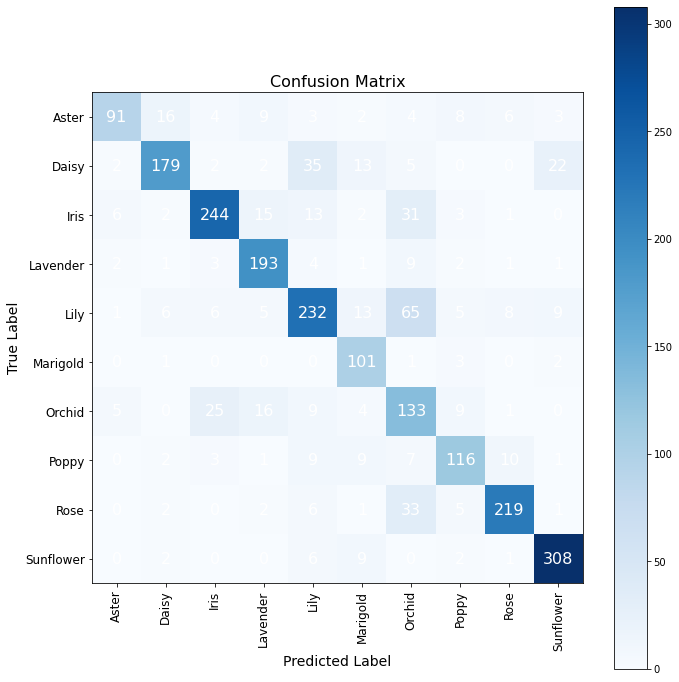

In [31]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
# Plot the confusion matrix with label names
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90, fontsize=12)
plt.yticks(tick_marks, class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Add the values to the cells of the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=16)

plt.tight_layout()
plt.show()

In [32]:
# Generate the classification report
target_names = class_names
print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

       Aster       0.85      0.62      0.72       146
       Daisy       0.85      0.69      0.76       260
        Iris       0.85      0.77      0.81       317
    Lavender       0.79      0.89      0.84       217
        Lily       0.73      0.66      0.70       350
    Marigold       0.65      0.94      0.77       108
      Orchid       0.46      0.66      0.54       202
       Poppy       0.76      0.73      0.75       158
        Rose       0.89      0.81      0.85       269
   Sunflower       0.89      0.94      0.91       328

    accuracy                           0.77      2355
   macro avg       0.77      0.77      0.76      2355
weighted avg       0.79      0.77      0.77      2355



In [33]:
# Calculate and print the precision, recall, accuracy, and F1-score
precision = sum([cm[i, i] / sum(cm[:, i]) for i in range(len(target_names))]) / len(target_names)
recall = sum([cm[i, i] / sum(cm[i, :]) for i in range(len(target_names))]) / len(target_names)
accuracy = sum([cm[i, i] for i in range(len(target_names))]) / np.sum(cm)
f1_score = 2 * (precision * recall) / (precision + recall)

print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('F1-score: {:.2f}%'.format(f1_score * 100))


Precision: 77.21%
Recall: 77.15%
Accuracy: 77.11%
F1-score: 77.18%


In [39]:
#Saving metrics for plotting future
metrics_as_numpy = np.array(metrics)

# Save the NumPy array to a file
np.save('Dataset2_Resnet_metrics.npy', metrics_as_numpy)

In [40]:
# Move the model file to DRIVE

# Define the file path in the Colab environment
model_file_path = '/content/model_checkpoint.pth'
metrics_file_path = '/content/Dataset2_Resnet_metrics.npy'

# Define the destination directory in your Google Drive
drive_dir = '/content/gdrive/MyDrive/FlowerDataset/'

# Move the file to your Google Drive
shutil.copy(model_file_path, drive_dir)
shutil.copy(metrics_file_path, drive_dir)

'/content/gdrive/MyDrive/FlowerDataset/Dataset2_Resnet_metrics.npy'